In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from umap import UMAP

In [89]:
df = pd.read_csv('data/train.csv')

In [115]:
df

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,13829,NaN,technician,single,tertiary,no,NaN,no,no,cellular,11,unknown,2,0,0,unknown,0
1,22677,NaN,services,single,secondary,no,NaN,yes,yes,unknown,5,unknown,3,0,0,unknown,0
2,10541,NaN,management,single,secondary,no,NaN,no,no,cellular,14,unknown,2,0,0,unknown,0
3,13689,NaN,technician,married,unknown,no,NaN,yes,no,cellular,10,unknown,1,0,0,unknown,0
4,11304,NaN,admin.,single,secondary,no,NaN,no,yes,unknown,2,unknown,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,14023,47.0,technician,married,secondary,no,1167.0,yes,no,cellular,30,apr,1,87,5,failure,1
12866,17259,31.0,unknown,married,secondary,no,111.0,no,no,cellular,21,nov,2,93,2,failure,1
12867,15200,37.0,unemployed,single,tertiary,no,1316.0,yes,no,cellular,18,nov,1,172,2,failure,0
12868,13775,42.0,management,married,tertiary,no,479.0,yes,no,unknown,28,may,2,0,0,unknown,0


In [91]:
# сохраняю target в отдельную переменную
df['y'] = df['y'].replace('yes', 1)
df['y'] = df['y'].replace('no', 0)
Y = df['y']

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12870 entries, 0 to 12869
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         12870 non-null  int64  
 1   age        12282 non-null  float64
 2   job        12870 non-null  object 
 3   marital    12870 non-null  object 
 4   education  12870 non-null  object 
 5   default    12870 non-null  object 
 6   balance    12865 non-null  float64
 7   housing    12870 non-null  object 
 8   loan       12870 non-null  object 
 9   contact    12870 non-null  object 
 10  day        12870 non-null  int64  
 11  month      12865 non-null  object 
 12  campaign   12870 non-null  int64  
 13  pdays      12870 non-null  int64  
 14  previous   12870 non-null  int64  
 15  poutcome   12870 non-null  object 
 16  y          12870 non-null  int64  
dtypes: float64(2), int64(6), object(9)
memory usage: 1.7+ MB


In [93]:
df.describe()

,ID,age,balance,day,campaign,pdays,previous,y
count,12870.000000,12282.000000,12865.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000
mean,16434.500000,41.087689,1482.854644,15.641103,2.659130,45.555478,0.688967,0.308236
std,3715.393317,11.311299,3308.322822,8.368983,2.863507,104.449411,2.049696,0.461783
min,10000.000000,18.000000,-6847.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,13217.250000,32.000000,102.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,16434.500000,39.000000,515.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,19651.750000,49.000000,1592.000000,21.000000,3.000000,-1.000000,0.000000,1.000000
max,22869.000000,95.000000,102127.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [94]:
type_obj = [i for i in df.columns if df[i].dtype == 'O']
type_obj

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [95]:
# проверяю на наличие пропусков в df
is_null_dict = df.isna().sum().to_dict()
null_columns = {k:v for k,v in is_null_dict.items() if v > 0}
null_columns

{'age': 588, 'balance': 5, 'month': 5}

In [96]:
# группировка по ID переменных типа object 
job = df.groupby('job')[['ID']].count()
marital = df.groupby('marital')[['ID']].count()
education = df.groupby('education')[['ID']].count()
default = df.groupby('default')[['ID']].count()
housing = df.groupby('housing')[['ID']].count()
loan = df.groupby('loan')[['ID']].count()
contact = df.groupby('contact')[['ID']].count()
poutcome = df.groupby('poutcome')[['ID']].count()
month = df.groupby('month')[['ID']].count()

In [ ]:
# Распределение числовых переменных
num_obj = [i for i in df.columns if (df[i].dtype == 'int') or (df[i].dtype == 'float')]
print(num_obj)
for i in num_obj[1:]:
    # print(f'Минимальное значение {i}:', df[i].min())
    plt.figure(figsize=(10, 7))
    plt.title(f'Распределение переменной {i}')
    plt.hist(df[i], bins=60)
    plt.xlabel(f'Минимальный {i}: {df[i].min()} \n Максимальный {i}: {df[i].max()}', fontsize= 14)
    # print(f'Максимальное значение {i}:', df[i].max())

In [98]:
# группировка по ID переменных типа object 
job = df.groupby('job')[['ID']].count()
marital = df.groupby('marital')[['ID']].count()
education = df.groupby('education')[['ID']].count()
default = df.groupby('default')[['ID']].count()
housing = df.groupby('housing')[['ID']].count()
loan = df.groupby('loan')[['ID']].count()
contact = df.groupby('contact')[['ID']].count()
poutcome = df.groupby('poutcome')[['ID']].count()
month = df.groupby('month')[['ID']].count()

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной job')
plt.bar(job.index, job["ID"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной marital')
plt.bar(marital.index, marital["ID"]);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной education')
plt.bar(education.index, education["ID"]);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной default')
plt.bar(default.index, default["ID"]);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной housing')
plt.bar(housing.index, housing["ID"]);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной loan')
plt.bar(loan.index, loan["ID"]);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной contact')
plt.bar(contact.index, contact["ID"]);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной poutcome')
plt.bar(poutcome.index, poutcome["ID"]);

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной month')
plt.bar(month.index, month["ID"]);

In [108]:
# пропущеное значение месяца заменяю на unknown
df['month'] = df['month'].fillna('unknown')

In [111]:
# заменил значения в pdays, где с клиентом связывались с -1 на 0 
df.loc[(df['pdays'] < 0), ('pdays')] = 0

In [153]:
is_null_dict = df.isna().sum().to_dict()
null_columns = {k:v for k,v in is_null_dict.items() if v > 0}
null_columns

{'age': 588, 'balance': 5}

In [171]:
# BASELINE
df_baseline = pd.get_dummies(df, columns = type_obj)

# заполняю пропуски при помощи IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter= 5, random_state= 42)
df_iter_imput_baseline = pd.DataFrame(imp.fit_transform(df_baseline))

# возвращаю названия колонкам после заполнения пропусков 
for dq_c, df_c in zip(df_iter_imput_baseline.columns.to_list(), df_baseline.columns.to_list()):
    df_iter_imput_baseline.rename(columns = {dq_c : df_c}, inplace = True)

# удаляю target из выборки
df_iter_imput_baseline = df_iter_imput_baseline.drop(['y'], axis = 1)

# разбиваю выборку на valid и train
X_train, X_valid, y_train, y_valid = train_test_split(df_iter_imput_baseline, Y, random_state=42)

cat_clt = CatBoostClassifier(verbose=False)
cat_clt.fit(X_train, y_train)

print("train acc:", roc_auc_score(cat_clt.predict(X_train), y_train))
print("valid acc:", roc_auc_score(cat_clt.predict(X_valid), y_valid))

train acc: 0.8599117586675938
valid acc: 0.7678406787028174


In [121]:
df[df['ID'] == 22869]

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
5739,22869,46.0,admin.,married,unknown,no,1106.0,no,no,telephone,9,feb,13,0,0,unknown,0


In [ ]:
df.groupby('ID')[['pdays', 'previous']].sum()

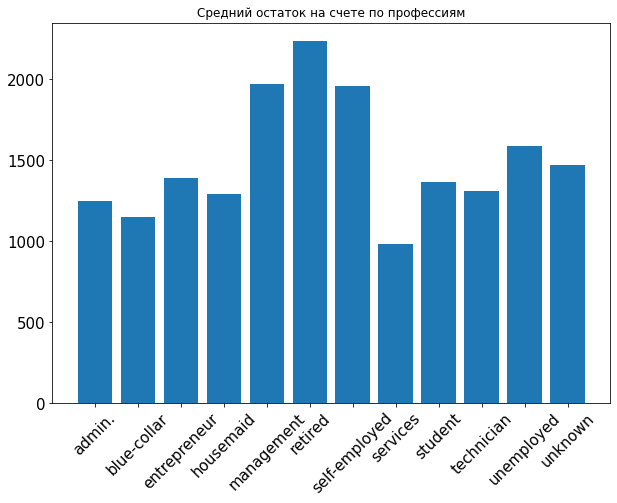

In [137]:
job_balance = df.groupby('job')[['balance']].mean()

plt.figure(figsize=(10, 7))
plt.title('Средний остаток на счете по профессиям')
plt.bar(job_balance.index, job_balance["balance"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

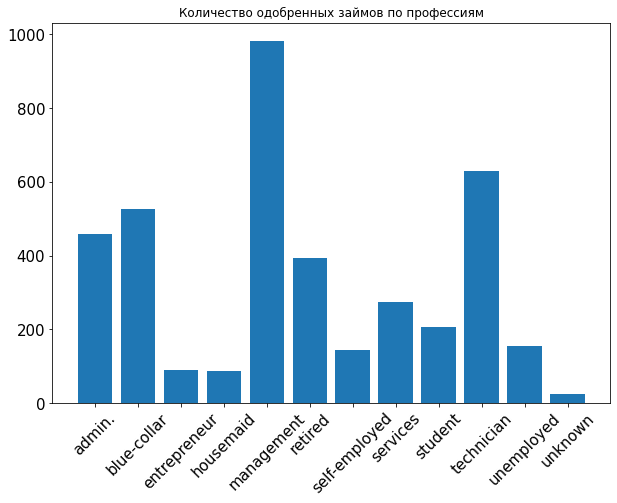

In [142]:
df_y_1 = df[df['y'] == 1]
job_y = df_y_1.groupby('job')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов по профессиям')
plt.bar(job_y.index, job_y["y"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

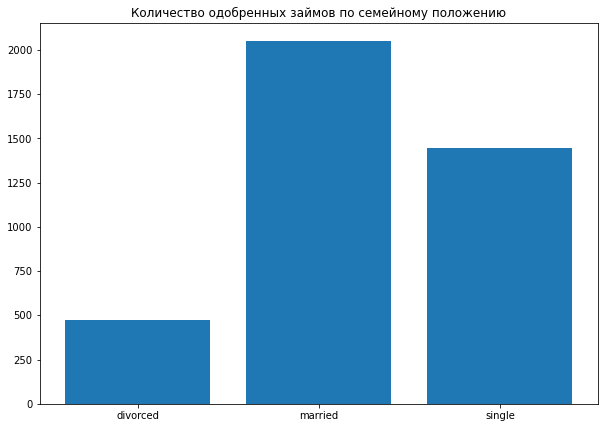

In [147]:
marital_y1 = df_y_1.groupby('marital')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов по семейному положению')
plt.bar(marital_y1.index, marital_y1["y"]);

In [ ]:
education

In [12]:
df = pd.get_dummies(df, columns = type_obj)

In [13]:
# заполняю пропуски при помощи IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
imp = IterativeImputer(max_iter= 5, random_state= 42)
df_iter_imput = pd.DataFrame(imp.fit_transform(df))

# возвращаю названия колонкам после заполнения пропусков 
for dq_c, df_c in zip(df_iter_imput.columns.to_list(), df.columns.to_list()):
    df_iter_imput.rename(columns = {dq_c : df_c}, inplace = True)

In [5]:
df_test = pd.read_csv('data/test.csv')

In [6]:
df_test

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,53608,32,management,single,tertiary,no,12569,no,no,cellular,1,jul,2,295,2,success
1,51055,25,services,single,secondary,no,801,no,no,cellular,5,jun,2,-1,0,unknown
2,52573,46,blue-collar,married,secondary,no,1728,yes,no,unknown,26,may,2,-1,0,unknown
3,50458,39,management,divorced,secondary,no,51,no,no,unknown,17,jun,2,-1,0,unknown
4,52272,31,services,single,tertiary,no,1626,no,no,unknown,31,jul,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,50332,47,admin.,married,secondary,no,520,no,no,telephone,9,feb,6,-1,0,unknown
4287,51293,33,technician,married,secondary,no,133,no,no,cellular,12,nov,2,192,1,success
4288,54023,40,admin.,married,secondary,no,2574,yes,no,cellular,20,nov,1,-1,0,unknown
4289,53775,39,blue-collar,married,secondary,no,2467,no,no,cellular,19,jul,2,276,3,other


In [10]:
# проверяю на наличие пропусков в df_test
df_test_is_null_dict = df_test.isna().sum().to_dict()
df_test_null_columns = {k:v for k,v in df_test_is_null_dict.items() if v > 0}
df_test_null_columns

{}